In [3]:
import numpy as np
import matplotlib.pyplot as plt

tau= 0.1
poissons_ratio = 0.20
E = 0.2 
Initial_stress = 200     #MPa
Inner_radius = 1 
outer_radius = 20
Epsilon = 0              #Gauss point
delta_u = 1

n = 10
Shape_func = np.array([1/2*(1-Epsilon),1/2*(1+Epsilon)])
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.005



#displacement_1 = 1/3*tau*volumetric_strain*Inner_radius
C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])


coordinate = np.linspace(Inner_radius,outer_radius,n+1)
Global_K = np.zeros((n+1,n+1))                       # Zero matrix of order (n+1,n+1) for adding elemental stiffness


#Global_displacement = np.zeros((n+1,1))
d = np.linspace(0,(1/3*tau*(-volumetric_strain)*Inner_radius),n+1).reshape((n+1,1)) #Initial guess
Global_displacement = np.flip(d,0)
Global_F_ext = np.zeros((n+1,1))                                                    # Zero matrix of order (n+1,1) to add force matrix
Reduced_displacement = np.delete(Global_displacement,(0),axis=0)



for i in range(len(coordinate)-1):
    def element_routine(coordinate):
        Derivative_N = np.array([-1/2,1/2])
        Jacobian = Derivative_N@np.array([[coordinate[i]],
                                          [coordinate[i+1]]])
        J_inv = np.asscalar(1/Jacobian)
        
        B = np.array([[-1/2*J_inv,1/2*J_inv],
                      [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                      [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])
    
        B_T = np.transpose(B)
        Element_stiffness = 2*(B_T@(material_routine(Lambda,mu))@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2
        return Element_stiffness,J_inv
    
    
        
    def material_routine(Lambda,mu):
        return C
 
    #Assignmnet matrix
    Ae = np.zeros((2,n+1))
    Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
    Ae[1,i+1]  =1
    AeT = np.transpose(Ae)
    
    Ke,J_i = element_routine(coordinate)
    #Global stiffness matrix
    K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
    Global_K = np.add(Global_K,K)                        # Global stiffnes matrix
    K_red = np.delete(Global_K,(0),axis=0)
    K_red = np.delete(K_red,(0),axis=1)
    
    #External force calculation
    sigma_rr = 2*mu*J_i*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain
  
    Fe_ext = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                       [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
    
    F_ext = AeT@Fe_ext                                   # Force vector of each element after transformation
    Global_F_ext=np.add(Global_F_ext,F_ext)              # Global F matrix
    Global_F_ext[-1]=0                                   # Global F matrix
print(Global_F_ext)



    
#Newton Raphson method
while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Reduced_displacement)):
   
    G_matrix = Global_K@Global_displacement - Global_F_ext
    G_red = np.delete(G_matrix,(0),axis=0)
    delta_u = np.linalg.inv(K_red)@G_red
    Reduced_displacement = Reduced_displacement - delta_u
    
    Global_displacement = np.insert(Reduced_displacement,(0),(1/3*tau*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
    print(Global_displacement)



[[ 2.92397661e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.33680869e-19]
 [-8.67361738e-19]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[1.66666667e-04]
 [1.53867266e-05]
 [5.61257430e-06]
 [2.94098477e-06]
 [1.85564952e-06]
 [1.31970837e-06]
 [1.02368376e-06]
 [8.48930572e-07]
 [7.42023420e-07]
 [6.76020666e-07]
 [6.36139184e-07]]
[[1.66666667e-04]
 [1.53867266e-05]
 [5.61257430e-06]
 [2.94098477e-06]
 [1.85564952e-06]
 [1.31970837e-06]
 [1.02368376e-06]
 [8.48930572e-07]
 [7.42023420e-07]
 [6.76020666e-07]
 [6.36139184e-07]]


[1.66666667e-04 1.98176774e-05 7.23379630e-06 3.71277939e-06
 2.25347034e-06 1.51171580e-06 1.08394034e-06 8.15035780e-07
 6.35065793e-07 5.08734980e-07 4.16666667e-07]


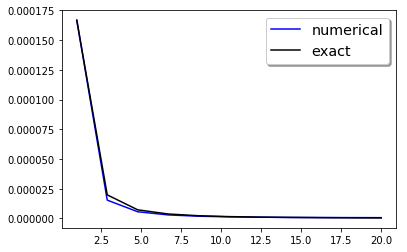

In [4]:
u_elastic = ((Inner_radius)**3*(-volumetric_strain)*tau)/(3*(coordinate)**2)
print(u_elastic)
fig,ax = plt.subplots()
ax.plot(coordinate,Global_displacement,'b',label='numerical')
ax.plot(coordinate,u_elastic,'k',label='exact')
ax.legend(loc='upper right', shadow=True, fontsize='x-large')